# Table of Contents

1. Import Libraries
2. Load Dataset
3. Preprocessing and Exploring Text Data
  
  3.1 Text Cleaning
  
  3.2 Finding Word Count

  3.3 Find and Replace Rare Words with "Unknown" Token

4. Data Preparation

  4.1 Prepare Sequences

  4.2 Create Token-Integer Mappings

  4.3 Split Data into Train and Validation Sets

  4.4 Pad Sequences

  4.5 Convert Text Sequences to Integer Sequences
5. Model Building

  5.1 Define Model Architecture
  
  5.2 Start Model Training
6. Text Generation

# 1. Import Libraries

In [6]:
import pandas as pd
import numpy as np
import pickle
import re
import random
from tqdm import tqdm_notebook

import torch
from torch import nn
import torch.nn.functional as F
import os


In [ ]:
# reproducing same results
SEED = 2019

# torch
torch.manual_seed(SEED)

# 2. Load Dataset

In [1]:
# Read the text file with sentences line by line
# open text file and read in data
with open("/content/smaller_sen_story.txt", "r") as f:
    sentences = f.readlines()
# Process and enclose each sentence with single quotes
processed_sentences = [ sentence.strip() for sentence in sentences]

# Store the processed sentences in a list
sentence_list = processed_sentences

# Now, 'sentence_list' is a list of sentences with each sentence enclosed in single quotes
print(sentence_list)

['Title: "Island of Secrets" Once upon a time,', 'on a remote and mysterious island known as', 'Enigma Isle, the lush greenery extended as far', 'as the eye could see Towering palm trees', 'swayed gently in the warm tropical breeze, their', 'fronds whispering secrets to the azure sky above', 'The island was untouched by the outside world,', 'a place of unparalleled beauty and intrigue In', 'the heart of this paradise, there lived a', 'young and adventurous botanist named Amelia She had', 'arrived on Enigma Isle with one mission in', 'mind: to study the unique flora that flourished', 'there, many of which were found nowhere else', 'on Earth Amelia was known for her boundless', 'curiosity and unwavering determination, traits that had drawn', "her to the island's hidden wonders Accompanying her", 'was Captain Jonah, a rugged and weathered sea', 'captain with a heart as vast as the', "ocean itself He had sailed the world's roughest", 'waters and was drawn to Enigma Isle by', 'rumors of tre

In [2]:
len(sentence_list)

1589

In [3]:
df = sentence_list

Note: This is a subset of the Taskmaster dataset available under the Creative Commons Attribution 4.0 License. A full copy of the license can be found at https://creativecommons.org/licenses/by/4.0/. You can access the full dataset from [here](https://github.com/google-research-datasets/Taskmaster/tree/master/TM-1-2019).  

In [4]:
df

['Title: "Island of Secrets" Once upon a time,',
 'on a remote and mysterious island known as',
 'Enigma Isle, the lush greenery extended as far',
 'as the eye could see Towering palm trees',
 'swayed gently in the warm tropical breeze, their',
 'fronds whispering secrets to the azure sky above',
 'The island was untouched by the outside world,',
 'a place of unparalleled beauty and intrigue In',
 'the heart of this paradise, there lived a',
 'young and adventurous botanist named Amelia She had',
 'arrived on Enigma Isle with one mission in',
 'mind: to study the unique flora that flourished',
 'there, many of which were found nowhere else',
 'on Earth Amelia was known for her boundless',
 'curiosity and unwavering determination, traits that had drawn',
 "her to the island's hidden wonders Accompanying her",
 'was Captain Jonah, a rugged and weathered sea',
 'captain with a heart as vast as the',
 "ocean itself He had sailed the world's roughest",
 'waters and was drawn to Enigma Isle 

# 3. Preprocessing and Exploring Text Data

## 3.1 Text Cleaning

In [7]:
# text cleaning
sentences_clean = []

for i in df:
  # remove everything except alphabets
  i = re.sub("[^a-zA-Z' ]", "", i)
  # convert text to lowercase
  i = i.lower()
  # add cleaned text to the list
  sentences_clean.append(i)

In [8]:
random.sample(sentences_clean, 10)

['ethics of interdimensional travel and the essence of',
 "ensuring that the island's wisdom was shared with",
 'new era of harmony',
 'of portals that connected every conceivable reality',
 'shores it had become a global legend inspiring',
 'what could be achieved when hearts and minds',
 'world had reconnected with ancient traditions and a',
 'principles of sustainability harmony with nature and the',
 'the hearts and hands of those who dared',
 'engaged in interstellar diplomacy']


## 3.2 Finding Word Count

In [9]:
# get list of all the words
all_words = " ".join(sentences_clean).split()

words_dict = {}

# add word-count pair to the dictionary
for word in all_words:
  # check if the word is already in dictionary
  if word in words_dict:
    # increment count of word by 1
    words_dict[word] = words_dict[word] + 1
  else:
    # add the word to dictionary with count 1
    words_dict[word] = 1

In [10]:
# prepare a dataframe
words_df = pd.DataFrame({'word':list(words_dict.keys()), 'count':list(words_dict.values())})

# sort words by their count in increasing order
words_df = words_df.sort_values(by = ['count'])

# reset dataframe index
words_df.reset_index(inplace = True, drop=True)

In [11]:
words_df

,word,count
0,title,1
1,habitat,1
2,safeguard,1
3,divides,1
4,traditional,1
...,...,...
1683,to,298
1684,a,411
1685,and,444
1686,of,663


In [12]:
# vocabulary size
len(words_df)

1688

In [13]:
words_df.head()

,word,count
0,title,1
1,habitat,1
2,safeguard,1
3,divides,1
4,traditional,1


In [123]:
words_df.tail()

,word,count
558,his,45
559,of,49
560,and,68
561,to,70
562,the,95


## 3.3 Find and Replace Rare Words with "Unknown" Token

In [18]:
# user specified threshold value
rare_thresh = 2

# get percentage of rare words in the vocabulary
rare_words_count = len(words_df[words_df['count'] < rare_thresh]['word'])
total_words = len(words_df)
rare_dist = rare_words_count / total_words

# coverage percentage of rare words in the corpus
rare_cover = words_df[words_df['count'] < rare_thresh]['count'].sum()/words_df['count'].sum()

In [19]:
print(f"Rare words distribution in the vocabulary: {rare_dist*100:.2f}")
print(f"Rare words coverage in the corpus: {rare_cover*100:.2f}")

Rare words distribution in the vocabulary: 44.37
Rare words coverage in the corpus: 6.31


In [20]:
# extract rare words in a list
rare_words = words_df[words_df['count'] < rare_thresh]['word'].tolist()

In [21]:
rare_words

['title',
 'habitat',
 'safeguard',
 'divides',
 'traditional',
 'cultivated',
 'ethos',
 'prioritized',
 'wellbeing',
 'transition',
 'awakened',
 'urgent',
 'reimagined',
 'proven',
 'indeed',
 'brightly',
 'compassion',
 'legenda',
 'storytellers',
 'sung',
 'bards',
 'indomitable',
 'craft',
 'body',
 'dreamers',
 'doers',
 'alike',
 'eden',
 'site',
 'lands',
 'responsible',
 'protectors',
 'mentored',
 'wave',
 'such',
 'food',
 'fisheries',
 'management',
 'approach',
 'interest',
 'ancestral',
 'demonstrate',
 'importance',
 'example',
 'humanitya',
 'measured',
 'shown',
 'monumental',
 'territories',
 'fueled',
 'ideals',
 'response',
 'passage',
 'enhanced',
 'persisted',
 'making',
 'platform',
 'ranging',
 'loss',
 'generated',
 'rippled',
 'outward',
 'right',
 'reside',
 'noble',
 'saved',
 'revival',
 'opened',
 'being',
 'heavens',
 'reach',
 'perpetual',
 'what',
 'background',
 'creed',
 'visions',
 'catalyst',
 'planetary',
 'scale',
 'lore',
 'songs',
 'farthest',


Let's see the technique that we will use to replace the rare words/tokens in the dataset with a special token known as the unknown token ("\<unk\>")

In [ ]:
## example
# specify rare words
r_words = ["day", "book"]

# build pattern
pattern = ""
for i in r_words:
  pattern+= "{}|".format(i)

print(pattern)

day|book|


In [ ]:
# removing the last element which is "|"
pattern = pattern[:-1]
print(pattern)

day|book


In [ ]:
# replace the rare words with the <unk> token
sents = ["it has been a long day", "this book is a must read"]

for d in sents:
  text = re.sub(pattern, " <unk> ", d)
  print(text)

it has been a long  <unk> 
this  <unk>  is a must read


In [22]:
# create a text pattern from the rare words, like "word1 | word2 | word3..."
pattern = ""
for i in rare_words:
  pattern+= " {} |".format(i)

# removing the last element which is "|"
pattern = pattern[:-1]

# empty list
dialogs_clean_v2 = []

# replace the rare words with the <unk> token
for d in tqdm_notebook(sentences_clean):
  text = re.sub(pattern, " <unk> ", d)
  dialogs_clean_v2.append(text)

<ipython-input-22-fdf5e49df05d>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for d in tqdm_notebook(sentences_clean):


  0%|          | 0/1589 [00:00<?, ?it/s]

In [23]:
dialogs_clean_v2[1500:1510]

['time and space were but illusions',
 'her chronicles now encompassed the stories of infinite',
 'universes each with its own cosmic saga',
 'the cosmic library extended into dimensions beyond reckoning',
 'housing knowledge that transcended the boundaries of comprehension',
 'cosmic voyagers embarked on odysseys that <unk> the',
 'very <unk> of existence',
 'they communed with sentient galaxies glimpsed the dreams',
 'of cosmic deities and played pivotal <unk> in',
 'the cosmic councilan assembly of beings who collectively']

# 4. Data Preparation

## 4.1 Prepare Sequences

<Axes: >

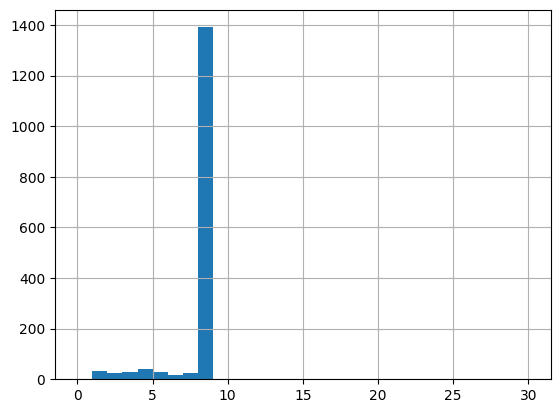

In [24]:
# capture length of all the sequences
text_word_count = []
for i in dialogs_clean_v2:
  text_word_count.append(len(i.split()))

# plot the sequence lengths
pd.Series(text_word_count).hist(bins = 30,range=(0,30))

In [25]:
# function to create sequences of equal length
def create_seq(text, seq_len = 9):

  sequences = []

  if len(text.split()) > seq_len:
    for i in range(seq_len, len(text.split())):
      # select sequence of tokens
      seq = text.split()[i-seq_len:i+1]
      # append sequence to the list
      sequences.append(" ".join(seq))

    return sequences

  else:

    return [text]

In [26]:
# create sequences of equal length
seqs = [create_seq(i) for i in dialogs_clean_v2]

In [27]:
seqs[:10]

[['title island of secrets once upon a time'],
 ['on a <unk> and mysterious island known as'],
 ['enigma isle the lush <unk> extended as far'],
 ['as the <unk> could see <unk> palm trees'],
 ['swayed <unk> in the <unk> tropical <unk> their'],
 ['fronds <unk> secrets to the <unk> sky above'],
 ['the island was <unk> by the outside world'],
 ['a place of <unk> beauty and <unk> in'],
 ['the heart of this paradise there lived a'],
 ['young and <unk> botanist <unk> amelia she had']]

In [28]:
# merge list-of-lists into a single list
seqs = sum(seqs, [])

In [29]:
seqs[:15]

['title island of secrets once upon a time',
 'on a <unk> and mysterious island known as',
 'enigma isle the lush <unk> extended as far',
 'as the <unk> could see <unk> palm trees',
 'swayed <unk> in the <unk> tropical <unk> their',
 'fronds <unk> secrets to the <unk> sky above',
 'the island was <unk> by the outside world',
 'a place of <unk> beauty and <unk> in',
 'the heart of this paradise there lived a',
 'young and <unk> botanist <unk> amelia she had',
 'arrived on enigma isle with one mission in',
 'mind to study the unique flora that flourished',
 'there <unk> of which were found <unk> else',
 'on earth amelia was known for her boundless',
 'curiosity and unwavering <unk> traits that had drawn']

In [30]:
# count of sequences
len(seqs)

1589

In [31]:
# create input and target sequences (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

In [32]:
len(x)

1589

In [138]:
x[275], y[275]

IndexError: ignored

## 4.2 Create Token-Integer Mappings

In [33]:
# create integer-to-token mapping
int2token = {}
cnt = 1

for w in set(" ".join(dialogs_clean_v2).split()):
  int2token[cnt] = w
  cnt+= 1

# create token-to-integer mapping
token2int = {t: i for i, t in int2token.items()}

In [50]:
token2int["the"], int2token[38]

(62, 'their')

## 4.3 Split Data into Train and Validation Sets

In [34]:
# train-validation split
# input sequences
x_tr = x[:1300]
x_val = x[1300:]

# target sequences
y_tr = y[:1300]
y_val = y[1300:]

## 4.4 Pad Sequences

<Axes: >

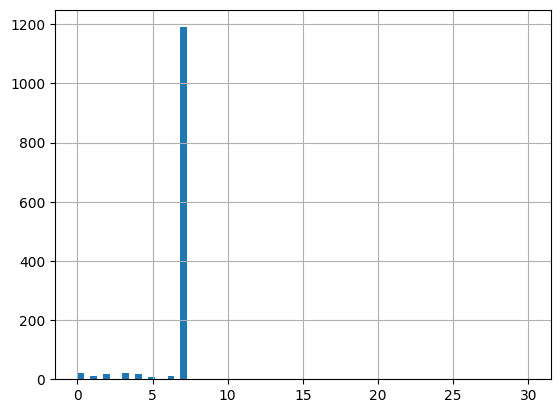

In [35]:
# plot sequence length in train set
text_word_count = []

for i in x_tr:
  text_word_count.append(len(i.split()))

pd.Series(text_word_count).hist(bins = 70,range=(0,30))

In [36]:
# based on the plot above
max_text_len = 7

# function to perform padding
def pad_sequence(seq, n):

  # split input sequence into tokens
  seq = seq.split()

  # check if no. of tokens in input sequence is less than 'n'
  if len(seq) < n:
    for i in range(n - len(seq)):
      seq.append("<pad>")

  return " ".join(seq)

# pad text sequences (train set)
x_tr_padded = [pad_sequence(s, max_text_len) for s in x_tr]
y_tr_padded = [pad_sequence(s, max_text_len) for s in y_tr]

# pad text sequences (validation set)
x_val_padded = [pad_sequence(s, max_text_len) for s in x_val]
y_val_padded = [pad_sequence(s, max_text_len) for s in y_val]

In [37]:
x_tr_padded[:20]

['title island of secrets once upon a',
 'on a <unk> and mysterious island known',
 'enigma isle the lush <unk> extended as',
 'as the <unk> could see <unk> palm',
 'swayed <unk> in the <unk> tropical <unk>',
 'fronds <unk> secrets to the <unk> sky',
 'the island was <unk> by the outside',
 'a place of <unk> beauty and <unk>',
 'the heart of this paradise there lived',
 'young and <unk> botanist <unk> amelia she',
 'arrived on enigma isle with one mission',
 'mind to study the unique flora that',
 'there <unk> of which were found <unk>',
 'on earth amelia was known for her',
 'curiosity and unwavering <unk> traits that had',
 "her to the island's hidden wonders <unk>",
 'was captain jonah a <unk> and <unk>',
 'captain with a heart as vast as',
 "ocean itself he had sailed the world's",
 'waters and was drawn to enigma isle']

In [38]:
y_tr_padded[:20]

['island of secrets once upon a time',
 'a <unk> and mysterious island known as',
 'isle the lush <unk> extended as far',
 'the <unk> could see <unk> palm trees',
 '<unk> in the <unk> tropical <unk> their',
 '<unk> secrets to the <unk> sky above',
 'island was <unk> by the outside world',
 'place of <unk> beauty and <unk> in',
 'heart of this paradise there lived a',
 'and <unk> botanist <unk> amelia she had',
 'on enigma isle with one mission in',
 'to study the unique flora that flourished',
 '<unk> of which were found <unk> else',
 'earth amelia was known for her boundless',
 'and unwavering <unk> traits that had drawn',
 "to the island's hidden wonders <unk> her",
 'captain jonah a <unk> and <unk> sea',
 'with a heart as vast as the',
 "itself he had sailed the world's roughest",
 'and was drawn to enigma isle by']

In [39]:
# update mapping dictionaries
int2token[0] = "<pad>"
token2int["<pad>"] = 0

# set vocabulary size
vocab_size = len(int2token)

## 4.5 Convert Text Sequences to Integer Sequences

In [40]:
# function to create integer sequences
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

In [41]:
# convert text sequences to integer sequences
x_tr_int = [get_integer_seq(i) for i in x_tr_padded]
y_tr_int = [get_integer_seq(i) for i in y_tr_padded]

x_val_int = [get_integer_seq(i) for i in x_val_padded]
y_val_int = [get_integer_seq(i) for i in y_val_padded]

In [42]:
x_tr_int[:10]

[[1025, 1185, 141, 481, 1039, 722, 33],
 [764, 33, 829, 239, 381, 1185, 946],
 [178, 263, 118, 555, 829, 111, 171],
 [171, 118, 829, 1095, 847, 829, 671],
 [585, 829, 447, 118, 829, 396, 829],
 [670, 829, 481, 973, 118, 829, 227],
 [118, 1185, 840, 829, 252, 118, 1015],
 [33, 981, 141, 829, 1044, 239, 829],
 [118, 897, 141, 105, 965, 917, 641],
 [1094, 239, 829, 983, 829, 534, 1008]]

In [43]:
y_tr_int[:10]

[[1185, 141, 481, 1039, 722, 33, 1198],
 [33, 829, 239, 381, 1185, 946, 171],
 [263, 118, 555, 829, 111, 171, 964],
 [118, 829, 1095, 847, 829, 671, 874],
 [829, 447, 118, 829, 396, 829, 876],
 [829, 481, 973, 118, 829, 227, 714],
 [1185, 840, 829, 252, 118, 1015, 1133],
 [981, 141, 829, 1044, 239, 829, 447],
 [897, 141, 105, 965, 917, 641, 33],
 [239, 829, 983, 829, 534, 1008, 787]]

In [44]:
# convert lists into numpy arrays
x_tr_int = np.array(x_tr_int)
y_tr_int = np.array(y_tr_int)

x_val_int = np.array(x_val_int)
y_val_int = np.array(y_val_int)

x_tr_int.shape, y_tr_int.shape, x_val_int.shape, y_val_int.shape

((1300, 7), (1300, 7), (289, 7), (289, 7))

# 5. Model Building

## 5.1 Define Model Architecture

In [45]:
# define model architecture

## embedding layer:
##    input dim = vocab_size,
##    ouput dim = 200

## LSTM layer:
##    input dim = 200
##    hidden units = 256
##    layers = 2
##    output dim = 256

## Dropout Layer
##    input dim = 256
##    output dim = 256

## fully connected layer
##    input dim = 256
##    ouput dim = vocab_size

class WordLSTM(nn.Module):

  def __init__(self, n_hidden=256, n_layers=2, drop_prob=0.3, lr=0.001):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr

    self.emb_layer = nn.Embedding(vocab_size, 200)

    ## define the LSTM
    # input data is of shape (batch size, sequence length, no. of features)...
    # ...therefore we need batch_first=True
    self.lstm = nn.LSTM(200, n_hidden, n_layers, batch_first=True)

    ## define a dropout layer
    self.dropout = nn.Dropout(drop_prob)

    ## define the fully-connected layer
    self.fc = nn.Linear(n_hidden, vocab_size)

  def forward(self, x, hidden):
    ''' Forward pass through the network.
        These inputs are x, and the hidden/cell state is `hidden`. '''

    ## pass input through embedding layer
    embedded = self.emb_layer(x)

    ## Get the outputs and the new hidden state from the lstm
    lstm_output, hidden = self.lstm(embedded, hidden)

    ## pass through a dropout layer
    out = self.dropout(lstm_output)

    ## reshape the tensor to the shape (batch-size*sequence length, hidden units)
    out = out.reshape(-1, self.n_hidden)

    ## put "out" through the fully-connected layer
    out = self.fc(out)

    # return the final output and the hidden state
    return out, hidden


  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

    if (torch.cuda.is_available()):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                weight.new(self.n_layers, batch_size, self.n_hidden).zero_())

    return hidden

In [46]:
# define and print the net
net = WordLSTM()
print(net)

WordLSTM(
  (emb_layer): Embedding(1203, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1203, bias=True)
)


In [47]:
# function to generate batches
def get_batches(arr_x, arr_y, batch_size):
  # iterate through the arrays
  prv = 0

  for n in range(batch_size, arr_x.shape[0], batch_size):
    # batch of input sequences
    x = arr_x[prv:n,:]

    # batch of target sequences
    y = arr_y[prv:n,:]

    prv = n

    yield x, y

## 5.2 Start Model Training

In [48]:
def train(net, epochs=10, batch_size=32, lr=0.001, print_every=32):

  # set initial loss to infinite
  best_valid_loss = float('inf')

  # optimizer
  opt = torch.optim.Adam(net.parameters(), lr=lr)

  # loss function
  criterion = nn.CrossEntropyLoss()

  if(torch.cuda.is_available()):
    # push model to GPU
    net.cuda()

  counter = 0

  net.train()

  for e in range(epochs):


    # iterate over batches
    for x, y in get_batches(x_tr_int, y_tr_int, batch_size):
      counter+= 1

      # convert arrays to tensors
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

      if(torch.cuda.is_available()):
        # push tensors to GPU
        inputs, targets = inputs.cuda(), targets.cuda()

      # initialize hidden state
      h = net.init_hidden(batch_size)

      # set accumulated gradients to zero
      net.zero_grad()

      # get the output from the model
      output, h = net(inputs, h)

      # calculate the loss and perform backprop
      loss = criterion(output, targets.view(-1))
      loss.backward()

      opt.step()

      if counter % print_every == 0:
        # Get validation loss

        val_losses = []

        net.eval()
        for x, y in get_batches(x_val_int, y_val_int, batch_size):

          x, y = torch.from_numpy(x), torch.from_numpy(y)

          val_h = net.init_hidden(batch_size)

          inputs, targets = x, y
          if(torch.cuda.is_available()):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)

          val_loss = criterion(output, targets.view(-1))
          val_losses.append(val_loss.item())

        #save the best model
        if np.mean(val_losses) < best_valid_loss:
          best_valid_loss = np.mean(val_losses)
          torch.save(net.state_dict(), '/content/lstm/runs/saved_weights.pt')

        # Check if the file exists
          if os.path.exists('/content/lstm/runs/saved_weights.pt'):
            print("Weights saved successfully.")
          else:
            print("Weights were not saved.")

        net.train()


        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "ppl: {:.4f} ".format(np.exp(np.mean(val_losses))),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [49]:
# specify batch size
batch_size = 32

# train the model
train(net, batch_size = batch_size, epochs=10)

Weights saved successfully.
Epoch: 1/10... Step: 32... Loss: 6.6932... ppl: 974.8394  Val Loss: 6.8823
Weights saved successfully.
Epoch: 2/10... Step: 64... Loss: 5.3782... ppl: 382.8103  Val Loss: 5.9475
Weights saved successfully.
Epoch: 3/10... Step: 96... Loss: 5.4391... ppl: 216.7265  Val Loss: 5.3786
Weights saved successfully.
Epoch: 4/10... Step: 128... Loss: 5.5762... ppl: 155.5384  Val Loss: 5.0469
Weights saved successfully.
Epoch: 4/10... Step: 160... Loss: 4.2266... ppl: 136.3725  Val Loss: 4.9154
Epoch: 5/10... Step: 192... Loss: 4.0678... ppl: 138.5618  Val Loss: 4.9313
Weights saved successfully.
Epoch: 6/10... Step: 224... Loss: 4.3815... ppl: 122.6341  Val Loss: 4.8092
Epoch: 7/10... Step: 256... Loss: 4.3456... ppl: 124.9438  Val Loss: 4.8279
Weights saved successfully.
Epoch: 8/10... Step: 288... Loss: 4.7823... ppl: 105.4369  Val Loss: 4.6581
Epoch: 8/10... Step: 320... Loss: 3.3974... ppl: 113.5153  Val Loss: 4.7319
Epoch: 9/10... Step: 352... Loss: 3.4184... ppl

# 6. Text Generation

In [50]:
#load weights of best model
path = '/content/lstm/runs/saved_weights.pt'
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [51]:
# function to generate one token
def predict(net, tkn, h=None):

  # tensor inputs
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)

  if(torch.cuda.is_available()):
      inputs = inputs.cuda()

  # get the output of the model
  out, h = net(inputs, h)

  # get the token probabilities
  p = F.softmax(out, dim=1).data

  if(torch.cuda.is_available()):
      p = p.cpu()

  p = p.numpy()
  sampled_token_index = np.argmax(p, axis = 1)[0]

  # return the encoded value of the predicted char and the hidden state
  return int2token[sampled_token_index], h

In [52]:
# function to fetch generated sequence
def sample(net, size = 2, seed_text='it is'):

    if(torch.cuda.is_available()):
        net.cuda()

    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = seed_text.split()

    # predict next token
    for t in toks:
      token, h = predict(net, t, h)

    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [58]:
# seed texts
seeds = ["curiosity and unwavering",
         "embarked",
         "symphony that transcended",
         "that echoed "]

# number of tokens to generate
num_toks = 6

# text generation
for s in seeds:
  # get generated text from the model
  print(s)
  text_gen = sample(net, num_toks, seed_text=s)
  # print the result
  print("seed text:", s, ">> output:",text_gen)
  print("\n")

curiosity and unwavering
seed text: curiosity and unwavering >> output: curiosity and unwavering the island's <unk> to the island's


embarked
seed text: embarked >> output: embarked of the island's monkey had become


symphony that transcended
seed text: symphony that transcended >> output: symphony that transcended the island's monkey had become a


that echoed 
seed text: that echoed  >> output: that echoed the island's of enigma isle had


